In [1]:
using Turing, AdvancedHMC, AbstractGPs, Stheno, ForwardDiff
using Distributions, Random
using LinearAlgebra
using CSV, Plots, DataFrames
using KernelFunctions
using LinearAlgebra
using Distances
using LogDensityProblems, LogDensityProblemsAD
using Memoize
using TransformVariables
using ProgressMeter
using Statistics, StatsPlots, StatsBase
using Profile, ProfileView, BenchmarkTools
using Pigeons
using MCMCChains
using FFTW, DSP
using Interpolations
using JLD2 #

In [2]:
#Define Constants
const G_N = 6.7e-11
const c = 3.0e8
const M_Sun = 2.0e30
const M = 4.1e6 * M_Sun
const tM_to_s = G_N * M / c^3

df = CSV.File("csv_orbiting_spot_60dot0_6dot0.csv")
t_imported = df.time

flux_imported = df.F_nu;

#Function to change Cadence: We want to match realistic cadence of EHT observations
original_cadence::Float64 = maximum(t_imported) / length(t_imported)
function subsample_data(time, data, new_cadence)
    subsample_factor = Int(new_cadence / original_cadence)
    return time[1:subsample_factor:end], data[1:subsample_factor:end]
end

subsample_data (generic function with 1 method)

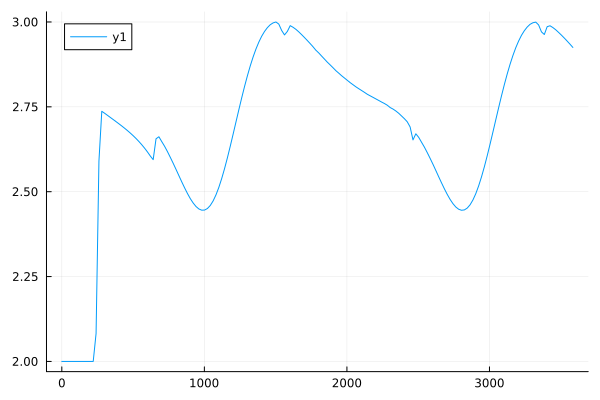

In [3]:
new_cadence = 20
m = maximum(flux_imported)
c = 1 / m
t, flux_obs = subsample_data(t_imported, (flux_imported*c).+2.0, new_cadence)

#flux_obs = log.(flux_obs)
mean_flux = mean(flux_obs)
#display(plot(t_imported, flux_imported)) #Optionally, compare new lightcurve to old one
display(plot(t, flux_obs))

In [22]:
"""
σ_turb = 0.28
τ_turb = 1.82 * 3600   
nu_turb = 0.80         
length_turb = τ_turb / sqrt(2nu_turb)  

k_base   = MaternKernel(; ν = nu_turb)             # unit length-scale
k_scaled = with_lengthscale(k_base, length_turb)       # set lengthscale
k_turb   = σ_turb^2 * k_scaled 

gp_turb = GP(k_turb)

rng          = MersenneTwister()  
δF_turb      = rand(rng, gp_turb(t)) 
flux_turbulent = flux_obs .+ δF_turb

max_attempts = 10
attempt = 0
flux_turbulent = copy(flux_obs)
min_flux_threshold = 1.8
max_flux_threshold = 3.5
valid_turbulence = false


while !valid_turbulence && attempt < max_attempts
    
    rng = MersenneTwister() 
    δF_turb = rand(rng, gp_turb(t)) 
    global flux_turbulent = flux_obs .+ δF_turb
    
    # Check if constraints are met
    if minimum(flux_turbulent) >= min_flux_threshold && maximum(flux_turbulent) <= max_flux_threshold
        valid_turbulence = true
        println("Successfully generated turbulent light curve after $(attempt+1) attempts.")
        println("Min flux: $(minimum(flux_turbulent)), Max flux: $(maximum(flux_turbulent))")
    else
        attempt += 1
        if attempt % 10 == 0
            println("Attempt $attempt: Light curve outside constraints (min=$(minimum(flux_turbulent)), max=$(maximum(flux_turbulent))). Retrying...")
        end
    end
end

if !valid_turbulence
    println("Failed to generate a light curve within constraints after $max_attempts attempts.")
    println("Using the last generated curve despite constraints not being met.")
end

# Plot the results
display(plot(t, flux_obs, label="Original"))
display(plot!(t, flux_turbulent, label="With Turbulence"))

LoadError: ParseError:
[90m# Error @ [0;0m]8;;file:///home/dashon/Desktop/EHT Photon Orbits research/Gaussian Processes/In[22]#51:59\[90mIn[22]:51:59[0;0m]8;;\
display(plot(t, flux_obs, label="Original"))
display(plot!(t, flux_turbulent, label="With Turbulence"))[48;2;120;70;70m[0;0m
[90m#                                                         └ ── [0;0m[91munterminated string literal[0;0m

In [ ]:
#flux_obs = flux_turbulent
mean_flux = mean(flux_obs)

2.687538404662085

In [9]:
#This cell block is for any calculations related to the Priors 
var_empirical = var(flux_obs, corrected=true)

0.06551074474124906

## Theoretical Parameter Values and Generalization

In [10]:
function Omega_K(r::Real)
    return 1.0 / r^(3/2)
end

function T_K(r::Real)
    return 2.0 * π * r^(3/2)
end

function phi_e_Hotspot(i::Real, r::Real, t::Real)
    T_K_Val = T_K(r)
    tan_phi_e = cos(i) * tan(Omega_K(r) * t)
    arctan_tan_phi_e = atan(tan_phi_e)
    
    phi_e_Val = 0.0
    
    if T_K_Val*(0.0/4.0) <= t < T_K_Val*(1.0/4.0)
        phi_e_Val = arctan_tan_phi_e + 0.0*π
    elseif T_K_Val*(1.0/4.0) <= t < T_K_Val*(3.0/4.0)
        phi_e_Val = arctan_tan_phi_e + 1.0*π
    elseif T_K_Val*(3.0/4.0) <= t < T_K_Val*(5.0/4.0)
        phi_e_Val = arctan_tan_phi_e + 2.0*π
    elseif T_K_Val*(5.0/4.0) <= t < T_K_Val*(7.0/4.0)
        phi_e_Val = arctan_tan_phi_e + 3.0*π
    elseif T_K_Val*(7.0/4.0) <= t < T_K_Val*(9.0/4.0)
        phi_e_Val = arctan_tan_phi_e + 4.0*π
    end
    
    return phi_e_Val
end

function th_e_Hotspot(i::Real, r::Real, t::Real)
    T_K_Val = T_K(r)
    arctan_tan_th_e = -atan(1.0/(tan(i)*sin(phi_e_Hotspot(i, r, t))))
    
    th_e_Val = 0.0
    
    if T_K_Val*(0.0/4.0) <= t < T_K_Val*(2.0/4.0)
        th_e_Val = arctan_tan_th_e + π
    elseif T_K_Val*(2.0/4.0) <= t < T_K_Val*(4.0/4.0)
        th_e_Val = arctan_tan_th_e
    elseif T_K_Val*(4.0/4.0) <= t < T_K_Val*(6.0/4.0)
        th_e_Val = arctan_tan_th_e + π
    elseif T_K_Val*(6.0/4.0) <= t < T_K_Val*(8.0/4.0)
        th_e_Val = arctan_tan_th_e
    elseif T_K_Val*(8.0/4.0) <= t < T_K_Val*(10.0/4.0)
        th_e_Val = arctan_tan_th_e + π
    end
    
    return th_e_Val
end



th_e_Hotspot (generic function with 1 method)

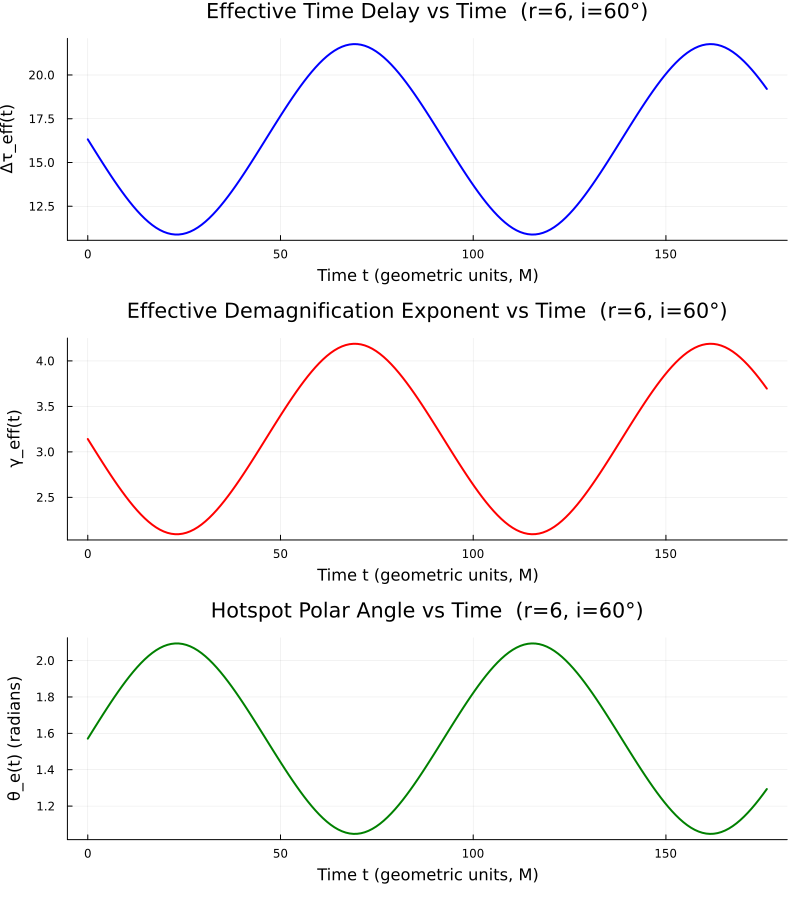

In [11]:
# Inputs for testing
t_geom = t/tM_to_s
r = 6.0
i_deg = 30.0
i = deg2rad(i_deg)  # convert to radians

# Constants for demonstration
tau = π   * sqrt(27)    
gamma_char = π # for Schwarzschild

# Compute arrays
theta_e = [th_e_Hotspot(i, r, t) for t in t_geom]
theta_e = mod.(theta_e, π)  # Ensure values are between 0 and π

delta_tau_eff = 2.0 .* tau .* (1.0 .- theta_e ./ π)
gamma_eff = 2.0 .* gamma_char .* (1.0 .- theta_e ./ π)

# Save CSV
df = DataFrame(
    t_geom = t_geom,
    theta_e = theta_e,
    delta_tau_eff = delta_tau_eff,
    gamma_eff = gamma_eff
)

p1 = plot(t_geom, delta_tau_eff,
    xlabel="Time t (geometric units, M)",
    ylabel="Δτ_eff(t)",
    title="Effective Time Delay vs Time  (r=6, i=60°)",
    legend=false,
    linewidth=2,
    color=:blue)
savefig(p1, "delta_tau_vs_time.png")


p2 = plot(t_geom, gamma_eff,
    xlabel="Time t (geometric units, M)",
    ylabel="γ_eff(t)",
    title="Effective Demagnification Exponent vs Time  (r=6, i=60°)",
    legend=false,
    linewidth=2,
    color=:red)
savefig(p2, "gamma_vs_time.png")

p3 = plot(t_geom, theta_e,
    xlabel="Time t (geometric units, M)",
    ylabel="θ_e(t) (radians)",
    title="Hotspot Polar Angle vs Time  (r=6, i=60°)",
    legend=false,
    linewidth=2,
    color=:green)
savefig(p3, "theta_e_vs_time.png")

# Combined plot
p_combined = plot(p1, p2, p3, layout=(3,1), size=(800, 900))
savefig(p_combined, "combined_plots.png")

# Return plots for display
p_combined

## GP Inference Sampling

In [12]:
# Define modified hotspot angle functions that use the sampled Ω
function T_K_withΩ(Ω::Real)
    return 2.0 * π / Ω
end

function phi_e_Hotspot_withΩ(i::Real, r::Real, t::Real, Ω::Real)
    T_K_Val = T_K_withΩ(Ω)
    tan_phi_e = cos(i) * tan(Ω * t)
    arctan_tan_phi_e = atan(tan_phi_e)
    
    phi_e_Val = 0.0
    
    if T_K_Val*(0.0/4.0) <= t < T_K_Val*(1.0/4.0)
        phi_e_Val = arctan_tan_phi_e + 0.0*π
    elseif T_K_Val*(1.0/4.0) <= t < T_K_Val*(3.0/4.0)
        phi_e_Val = arctan_tan_phi_e + 1.0*π
    elseif T_K_Val*(3.0/4.0) <= t < T_K_Val*(5.0/4.0)
        phi_e_Val = arctan_tan_phi_e + 2.0*π
    elseif T_K_Val*(5.0/4.0) <= t < T_K_Val*(7.0/4.0)
        phi_e_Val = arctan_tan_phi_e + 3.0*π
    elseif T_K_Val*(7.0/4.0) <= t < T_K_Val*(9.0/4.0)
        phi_e_Val = arctan_tan_phi_e + 4.0*π
    end
    
    return phi_e_Val
end

function th_e_Hotspot_withΩ(i::Real, r::Real, t::Real, Ω::Real)
    T_K_Val = T_K_withΩ(Ω)
    arctan_tan_th_e = -atan(1.0/(tan(i)*sin(phi_e_Hotspot_withΩ(i, r, t, Ω))))
    
    th_e_Val = 0.0
    
    if T_K_Val*(0.0/4.0) <= t < T_K_Val*(2.0/4.0)
        th_e_Val = arctan_tan_th_e + π
    elseif T_K_Val*(2.0/4.0) <= t < T_K_Val*(4.0/4.0)
        th_e_Val = arctan_tan_th_e
    elseif T_K_Val*(4.0/4.0) <= t < T_K_Val*(6.0/4.0)
        th_e_Val = arctan_tan_th_e + π
    elseif T_K_Val*(6.0/4.0) <= t < T_K_Val*(8.0/4.0)
        th_e_Val = arctan_tan_th_e
    elseif T_K_Val*(8.0/4.0) <= t < T_K_Val*(10.0/4.0)
        th_e_Val = arctan_tan_th_e + π
    end
    
    return th_e_Val
end

th_e_Hotspot_withΩ (generic function with 1 method)

In [12]:
@model function blackhole_gp_model(t, flux_obs, var_empirical, delta_t0_analytic)
    # Priors
    mean_flux = mean(flux_obs)
    ℓ_raw ~ Normal(0, 1)
    length_scale = 75.0 + (3000.0 - 75.0) * (1 / (1 + exp(-ℓ_raw)))  # logistic to (75,3000)

    log_variance ~ Truncated(
                  Normal(log(var_empirical), 0.5),
                  log(1e-12), Inf) #To avoid Scaled kernel error
    
    # Primary parameters we're measuring
    γ_raw   ~ Normal(0, 1)                # R → (0, 2π)
    gamma_PS = 2π * (1 / (1 + exp(-γ_raw)))                 # Characteristic demagnification exponent
    η_raw   ~ Normal(0, 1)                # R → (3, 6)
    η_ps     = 3.0 + 3.0 * (1 / (1 + exp(-η_raw)))                # Shadow radius parameter to sample
    
    # Orbital velocity parameter (sampling in log space)
    logΩ          ~ Normal(log(1/6^(3/2)), 0.3)      # Log of angular velocity
    Ω = exp(logΩ)                                    # Actual angular velocity
    
    # Fixed parameters for hotspot geometry
    r = 6.0                         # Fixed orbital radius at 6M
    i_raw   ~ Normal(0, 1)                # R → (0, π/2)
    i        = (π/2) * (1 / (1 + exp(-i_raw)))
    
    μ ~ Normal(mean_flux, 1.0)
    tinj_raw ~ Normal(0, 1)         
    t_inj    = 100.0 * (1 / (1 + exp(-tinj_raw)))
    #nu_fit ~ Uniform(0.5, 3.0)

    # Calculate time-dependent theta_e using modified functions 
    theta_e = zeros(length(t))
    for (idx, time) in enumerate(t)
        theta_val = th_e_Hotspot_withΩ(i, r, time, Ω)
        theta_e[idx] = mod(theta_val, π)  # Ensure values are between 0 and π
    end
    
    δ_t = 2.0 .* π .* η_ps .* (1.0 .- theta_e ./ π)
    w_t = exp.(-2.0 .* gamma_PS .* (1.0 .- theta_e ./ π))
    mask0 = t .> t_inj         # Primary image visibility
    mask1 = (t .- δ_t) .> t_inj # Secondary image visibility

    # Build Time Arrays with time-dependent delays
    t_combined = vcat(t, t .- δ_t)

    # Construct Mean & Kernel
    mean_func = ConstMean{Float64}(μ)
    variance = exp(log_variance)

    # Use Matern32 kernel as in your original code
    kernel = variance * with_lengthscale(Matern32Kernel(), length_scale)

    gp = GP(mean_func, kernel)

    f_t = gp(t_combined)
    mean_flux = mean(f_t)
    covariance = cov(f_t)

    # Extract F0 and F1 blocks
    n_obs = length(t)
    idxF0 = 1:n_obs
    idxF1 = (n_obs+1):(2*n_obs)

    mean_F0 = @view mean_flux[idxF0]
    mean_F1 = @view mean_flux[idxF1]
    cov_F0 = @view covariance[idxF0, idxF0]
    cov_F1 = @view covariance[idxF1, idxF1]
    cov_F0F1 = @view covariance[idxF0, idxF1]

    # Initialize an empty matrix for the total covariance
    total_cov = zeros(n_obs, n_obs)
    
    # Fill in the total covariance matrix following the K00, K01, K10, K11 structure
    for i in 1:n_obs
        for j in 1:n_obs
        # Each term is multiplied by the appropriate masks for times i and j
            term00 = mask0[i] * mask0[j] * cov_F0[i, j]
            term01 = mask0[i] * mask1[j] * cov_F0F1[i, j] * w_t[j]
            term10 = mask1[i] * mask0[j] * cov_F0F1[j, i] * w_t[i]
            term11 = mask1[i] * mask1[j] * cov_F1[i, j] * w_t[i] * w_t[j]
            total_cov[i, j] = term00 + term01 + term10 + term11
        end
    end
    jitter = 1e-9
    @inbounds for k in 1:n_obs
        total_cov[k,k] += jitter
    end

    total_cov_sym = Symmetric(total_cov)
    try
        flux_obs ~ MvNormal(mean_F0, total_cov_sym)
    catch e
        if isa(e, PosDefException)
            Turing.@addlogprob! -Inf     # soft-reject this draw
        else
            rethrow(e)                   # propagate unrelated errors
        end
    end
end

blackhole_gp_model (generic function with 2 methods)

In [13]:
delta_t0_analytic = 400.2672182312732/tM_to_s
t_geom = t/tM_to_s
my_model_instance = blackhole_gp_model(t_geom, flux_obs, var_empirical, delta_t0_analytic)

# Convert the Turing model to a LogPotential for use with Pigeons:
my_turing_potential = TuringLogPotential(my_model_instance)

TuringLogPotential{...}(DynamicPPL.Model{typeof(blackhole_gp_model), (:t, :flux_obs, :var_empirical, :delta_t0_analytic), (), (), Tuple{Vector{Float64}, Vector{Float64}, Float64, Float64}, Tuple{}, DynamicPPL.DefaultContext}(Main.blackhole_gp_model, (t = [0.0, 0.9842566436112122, 1.9685132872224245, 2.9527699308336364, 3.9370314888969786, 4.921283218056061, 5.905549690571533, 6.889816163087004, 7.874082635602476, 8.85829996359665  …  167.32382599199127, 168.30819075354933, 169.29206406989445, 170.27642883145248, 171.26079359301056, 172.24515835456862, 173.2295231161267, 174.2133964324718, 175.19776119402985, 176.1821259555879], flux_obs = [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0  …  2.986150728311157, 2.98883963339002, 2.983614204473689, 2.9770685825297143, 2.9693298999690447, 2.9612367984722976, 2.952670343162657, 2.9437330321827138, 2.9346060733833133, 2.9250057609697784], var_empirical = 0.06551074474124906, delta_t0_analytic = 19.670940830441165), NamedTuple(), DynamicPPL.

In [14]:
using MCMCChains

@time pt = pigeons(
    target = my_turing_potential, 
    n_chains = 2,
    n_rounds = 10,
    record   = [traces, online]
)

# After sampling, you can convert the samples to a Chains object for analysis
chain_data = sample_array(pt)


────────────────────────────────────────────────────────────────────────────
  scans        Λ      log(Z₁/Z₀)   min(α)     mean(α)    min(αₑ)   mean(αₑ) 
────────── ────────── ────────── ────────── ────────── ────────── ──────────
        2          1  -1.81e+10          0          0          1          1 
        4          1   -2.8e+10          0          0          1          1 
        8          1  -1.47e+09          0          0          1          1 
       16          1  -4.45e+08          0          0          1          1 
       32          1  -1.18e+09          0          0          1          1 
       64          1  -2.17e+08          0          0          1          1 
      128          1  -1.87e+07          0          0          1          1 
      256          1  -9.56e+07          0          0          1          1 
      512          1  -6.22e+08          0          0          1          1 
 1.02e+03          1  -1.23e+07          0          0          1          1 

1024×9×1 Array{Float64, 3}:
[:, :, 1] =
 -6.38986  3.39588  0.612188   0.333702   …  2.0      -2.02003  344.396
 -5.95536  3.57932  2.15784   -0.407624      2.00001  -2.02713  347.607
 -6.3125   3.45056  0.641546  -0.683464      2.00001  -2.10389  347.566
 -5.86781  3.38533  0.28512   -0.798756      1.99999  -2.02531  345.563
 -5.49973  3.75478  1.02337    0.939986      2.00001  -2.0868   347.719
 -6.19553  3.40831  0.819528   0.523502   …  2.0      -2.03436  350.693
 -5.96338  3.38095  2.93373   -0.167258      2.0      -2.04439  346.573
 -6.08548  3.45934  1.1138    -0.562403      2.00003  -2.05379  348.798
 -5.83687  3.51127  0.427824   0.0622502     2.0      -2.06076  348.613
 -6.36619  3.33779  0.805859   0.0250657     2.00003  -2.07398  343.089
 -6.63852  3.42672  1.80217    0.44708    …  1.99999  -2.04183  346.195
 -5.53993  3.62192  0.327275   0.1729        2.00001  -2.03839  349.514
 -6.33766  3.38183  0.960715   1.02892       2.00001  -2.10128  350.044
  ⋮                     

In [15]:
chain_obj  = Chains(pt)

Chains MCMC chain (1024×9×1 Array{Float64, 3}):

Iterations        = 1:1:1024
Number of chains  = 1
Samples per chain = 1024
parameters        = ℓ_raw, log_variance, γ_raw, η_raw, logΩ, i_raw, μ, tinj_raw
internals         = log_density

Summary Statistics
    parameters      mean       std   naive_se      mcse         ess      rhat 
        Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

         ℓ_raw   -6.1444    0.3873     0.0121    0.0140    820.3267    0.9994
  log_variance    3.4641    0.1279     0.0040    0.0038    944.1550    0.9993
         γ_raw    1.1050    0.6633     0.0207    0.0286    822.5977    1.0031
         η_raw   -0.0422    1.0186     0.0318    0.0295   1061.6131    1.0007
          logΩ   -2.7157    0.3341     0.0104    0.0156    481.2130    1.0010
         i_raw   -1.0037    0.7150     0.0223    0.0194    916.6290    0.9998
             μ    2.0000    0.0000     0.0000    0.0000    970.9679    0.9995
      tinj_raw   -2.0535    0.0270    

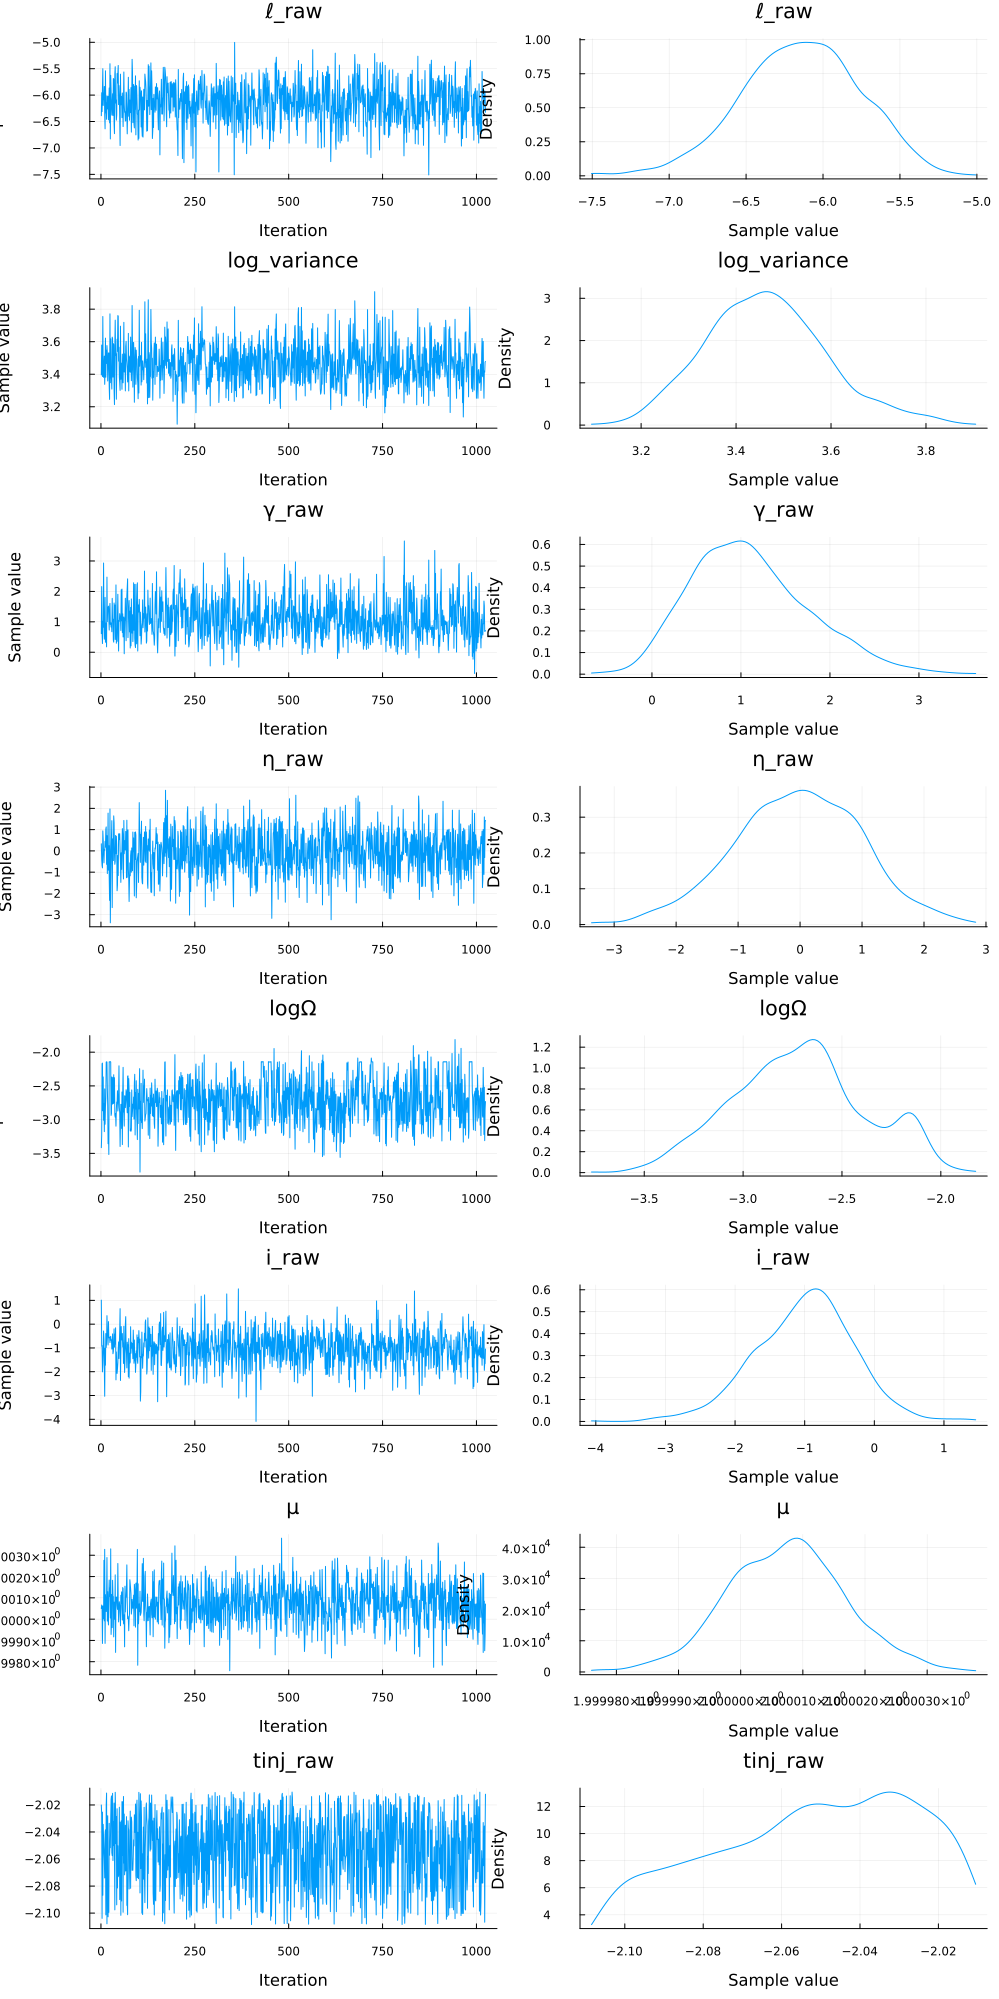

In [16]:
my_plot = StatsPlots.plot(chain_obj)

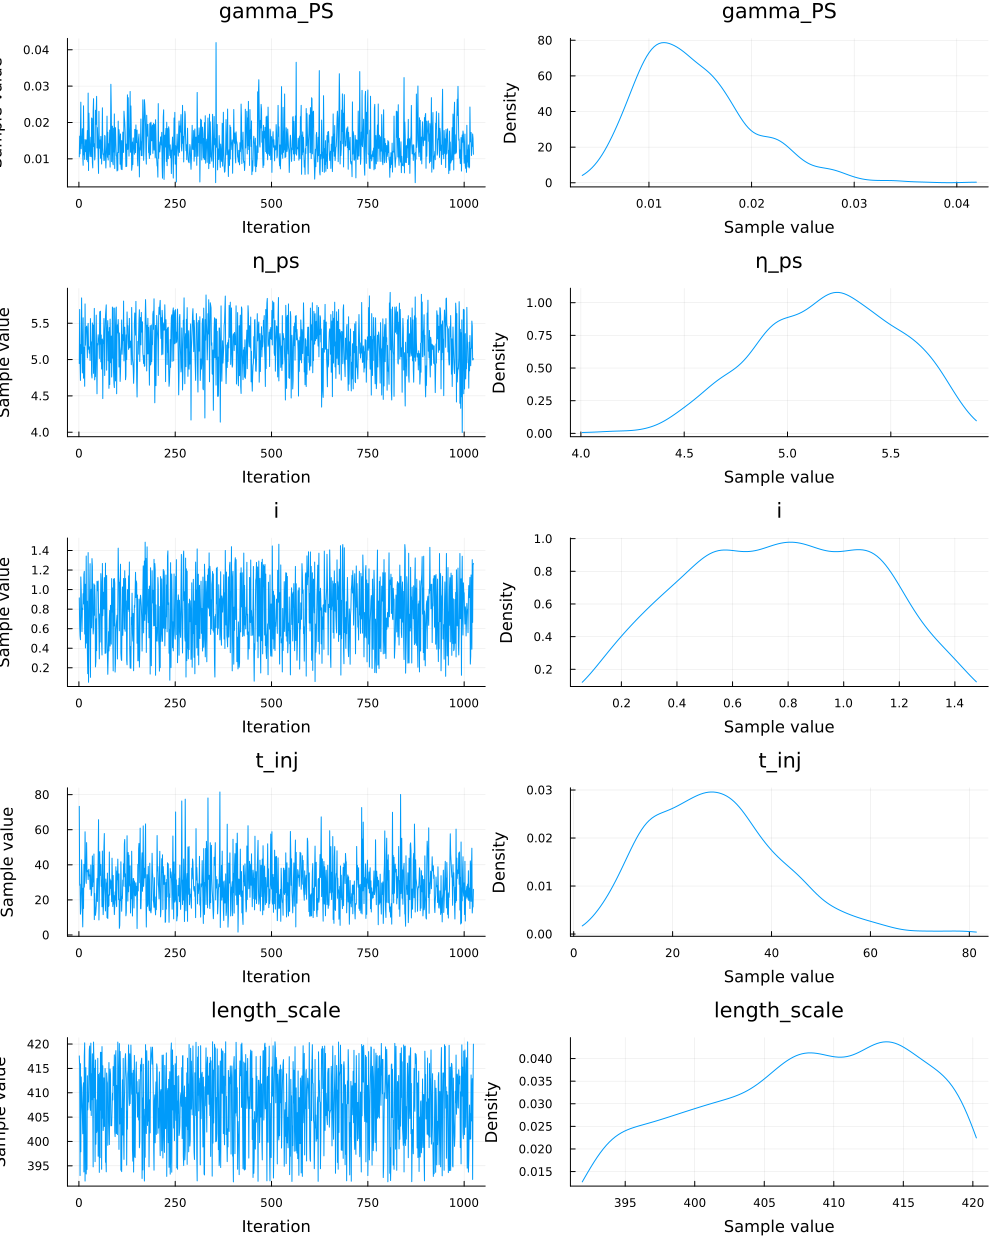

In [22]:
# helpers (same transforms you used in the model)
logistic(x) = 1 / (1 + exp(-x))
softplus_lower(x, a) = a + log1p(exp(x))           # maps ℝ → (a, ∞)

# extract raw draws you care about (handles all chains)
raw = Array(chain_obj[:, [:γ_raw, :η_raw, :i_raw, :tinj_raw, :ℓ_raw], :])  # (iters × params × chains)

γ_raw    = raw[:, 1, :]
η_raw    = raw[:, 2, :]
i_raw    = raw[:, 3, :]
tinj_raw = raw[:, 4, :]
ℓ_raw    = raw[:, 5, :]

# map to physical space (broadcast over iters × chains)
gamma_PS     = 2π .* logistic.(γ_raw)                                 # ∈ (0, 2π)
η_ps         = 3.0 .+ 3.0 .* logistic.(η_raw)                         # ∈ (3, 6)
i_phys       = (π/2) .* logistic.(i_raw)                              # ∈ (0, π/2)
t_inj_phys   = 100.0 .* logistic.(tinj_raw)                            # ∈ (0, 20)  (your geom units range)
length_scale = 75.0 .+ (3000.0 - 75.0) .* logistic.(ℓ_raw)            # ∈ (75, 3000)

phys_stack = cat(gamma_PS, η_ps, i_phys, t_inj_phys, length_scale; dims=2)  # iters × 5 × chains
param_names = Symbol[:gamma_PS, :η_ps, :i, :t_inj, :length_scale]
chain_phys = Chains(phys_stack, param_names)

plot(chain_phys)

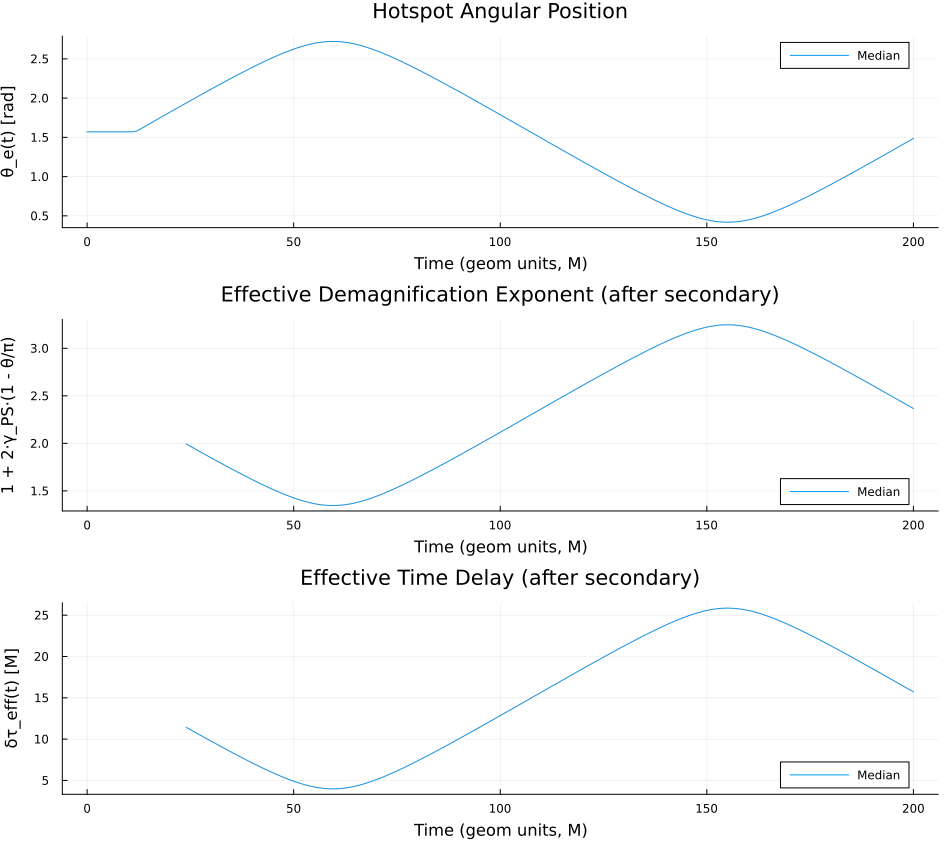

(Plot{Plots.GRBackend() n=6}, [1.5707963267948966 1.5707963267948966 … 1.4564271658231682 1.4864285543641382], Union{Missing, Float64}[missing missing … 2.3913050870786012 2.3665353627995973], Union{Missing, Float64}[missing missing … 16.00226290797273 15.717370943045829])

In [32]:
using MCMCChains, Statistics, StatsPlots
import MCMCChains: names as chain_names

logistic(x) = 1 / (1 + exp(-x))

function get_param_vec(chain_obj::Chains, param::Symbol)
    allnames = chain_names(chain_obj)
    if any(==(param), allnames)
        A = Array(chain_obj[:, param, :])        # (iters × 1 × chains)
        return reshape(A, size(A,1) * size(A,3)) # flatten over chains
    else
        return nothing
    end
end

function get_gamma_PS(chain_obj)
    if (v = get_param_vec(chain_obj, :γ_raw)) !== nothing
        return 2 .* logistic.(v)                 # γ_PS ∈ (0, 2)
    else
        return get_param_vec(chain_obj, :gamma_PS)
    end
end

function get_eta_ps(chain_obj; η_lo=3.0, η_hi=6.0)
    if (v = get_param_vec(chain_obj, :η_raw)) !== nothing
        return η_lo .+ (η_hi - η_lo) .* logistic.(v)
    else
        return get_param_vec(chain_obj, :η_ps)
    end
end

function get_inclination(chain_obj; i_max=π/2)
    if (v = get_param_vec(chain_obj, :i_raw)) !== nothing
        return i_max .* logistic.(v)
    else
        return get_param_vec(chain_obj, :i)
    end
end

function get_tinj(chain_obj; t_inj_max=100.0)
    if (v = get_param_vec(chain_obj, :tinj_raw)) !== nothing
        return t_inj_max .* logistic.(v)
    else
        return get_param_vec(chain_obj, :t_inj)
    end
end

function get_Omega(chain_obj; r_fixed=6.0)
    if (v = get_param_vec(chain_obj, :logΩ)) !== nothing
        return exp.(v)
    elseif (v = get_param_vec(chain_obj, :Ω)) !== nothing
        return v
    else
        n = length(get_inclination(chain_obj))
        return fill(r_fixed^(-3/2), n)
    end
end

function get_params(chain_obj)
    gamma_PS = get_gamma_PS(chain_obj)
    η_ps     = get_eta_ps(chain_obj)
    i_vec    = get_inclination(chain_obj)
    t_inj    = get_tinj(chain_obj)
    Ω_vec    = get_Omega(chain_obj)
    n = minimum(length.(Ref.([gamma_PS, η_ps, i_vec, t_inj, Ω_vec])))
    return Dict(
        "gamma_PS" => gamma_PS[1:n],
        "η_ps"     => η_ps[1:n],
        "i"        => i_vec[1:n],
        "t_inj"    => t_inj[1:n],
        "Ω"        => Ω_vec[1:n]
    )
end

median_skip(x) = (vals = collect(skipmissing(x)); isempty(vals) ? missing : median(vals))

function compute_and_plot_hotspot_properties(chain_obj, t_geom;
        n_draws=500, use_model_theta=true, plot_after::Symbol=:secondary,
        gamma_display::Symbol=:vida)

    @assert plot_after in (:injection, :secondary)
    @assert gamma_display in (:vida, :times2, :no2, :plus1)

    params = get_params(chain_obj)

    n_total = length(params["i"])
    draw_indices = (n_total > n_draws) ? rand(1:n_total, n_draws) : collect(1:n_total)
    n_draws = length(draw_indices)

    n_times = length(t_geom)
    θ_e_draws              = zeros(n_draws, n_times)
    gamma_eff_draws        = Array{Union{Missing,Float64}}(undef, n_draws, n_times)
    delta_tau_eff_draws    = Array{Union{Missing,Float64}}(undef, n_draws, n_times)

    r_val = 6.0  # fixed orbital radius

    for (k, d) in enumerate(draw_indices)
        i_val      = params["i"][d]
        γPS_val    = params["gamma_PS"][d]
        ηps_val    = params["η_ps"][d]
        Ω_val      = params["Ω"][d]
        t_inj_val  = params["t_inj"][d]

        # θ_e(t) using time since injection
        θ_values = zeros(n_times)
        if use_model_theta && @isdefined th_e_Hotspot_withΩ
            for (ti, t) in enumerate(t_geom)
                tprime = max(t - t_inj_val, 0.0)
                θ_values[ti] = mod(th_e_Hotspot_withΩ(i_val, r_val, tprime, Ω_val), π)
            end
        else
            for (ti, t) in enumerate(t_geom)
                tprime = max(t - t_inj_val, 0.0)
                phase01 = mod(tprime * Ω_val, 2π) / (2π)
                θ_raw = phase01 < 0.5 ? (phase01 * 2π) : ((1 - phase01) * 2π)
                θ_values[ti] = clamp(θ_raw, 0.0, π)
            end
        end
        θ_e_draws[k, :] = θ_values

        # Derived quantities
        γbase = (γps, θvals) -> γps .* (1 .- θvals ./ π)

        γeff = if gamma_display === :vida
            1 .+ 2 .* γbase(γPS_val, θ_values)
        elseif gamma_display === :times2
            2 .* γbase(γPS_val, θ_values)
        elseif gamma_display === :no2
            γbase(γPS_val, θ_values)
        else # :plus1
            1 .+ γbase(γPS_val, θ_values)
        end

        δτ   = 2.0 * π * ηps_val .* (1.0 .- θ_values ./ π)

        # Validity masks
        mask_inj = t_geom .>= t_inj_val
        mask_sec = t_geom .>= (t_inj_val .+ δτ)
        mask = plot_after === :secondary ? mask_sec : mask_inj

        # Apply masks via `missing`
        for ti in 1:n_times
            gamma_eff_draws[k, ti]     = mask[ti] ? γeff[ti] : missing
            delta_tau_eff_draws[k, ti] = mask[ti] ? δτ[ti]   : missing
        end
    end

    # Medians over draws (skip missings)
    θ_e_median           = [median(@view θ_e_draws[:, t]) for t in 1:n_times]
    gamma_eff_median     = [median_skip(@view gamma_eff_draws[:, t]) for t in 1:n_times]
    delta_tau_eff_median = [median_skip(@view delta_tau_eff_draws[:, t]) for t in 1:n_times]

    # Plots
    p1 = plot(t_geom, θ_e_median,
              xlabel="Time (geom units, M)", ylabel="θ_e(t) [rad]",
              title="Hotspot Angular Position", label="Median")

    suffix = plot_after === :secondary ? " (after secondary)" : " (after injection)"
    ylabel_gamma = gamma_display === :vida ? "1 + 2·γ_PS·(1 - θ/π)" :
                    gamma_display === :times2 ? "2·γ_PS·(1 - θ/π)" :
                    gamma_display === :no2 ? "γ_PS·(1 - θ/π)" : "1 + γ_PS·(1 - θ/π)"

    p2 = plot(t_geom, gamma_eff_median,
              xlabel="Time (geom units, M)", ylabel=ylabel_gamma,
              title="Effective Demagnification Exponent" * suffix, label="Median")

    p3 = plot(t_geom, delta_tau_eff_median,
              xlabel="Time (geom units, M)", ylabel="δτ_eff(t) [M]",
              title="Effective Time Delay" * suffix, label="Median")

    # overlay individual draws
    sample_draws = rand(1:n_draws, min(20, n_draws))
    for d in sample_draws
        plot!(p1, t_geom, θ_e_draws[d, :], alpha=0.15, label="")
        plot!(p2, t_geom, vec(gamma_eff_draws[d, :]), alpha=0.15, label="")
        plot!(p3, t_geom, vec(delta_tau_eff_draws[d, :]), alpha=0.15, label="")
    end

    p_combined = plot(p1, p2, p3, layout=(3,1), size=(950, 850))
    return p_combined, θ_e_draws, gamma_eff_draws, delta_tau_eff_draws
end

function run_hotspot_analysis(chain_obj; t_start=0.0, t_end=200.0, t_step=1.0,
        n_draws=500, use_model_theta=true, plot_after::Symbol=:secondary,
        gamma_display::Symbol=:vida)
    t_geom = collect(range(t_start, t_end; step=t_step))
    main_plots, θ_e_draws, γeff_draws, δτ_draws =
        compute_and_plot_hotspot_properties(chain_obj, t_geom;
            n_draws=n_draws, use_model_theta=use_model_theta,
            plot_after=plot_after, gamma_display=gamma_display)
    display(main_plots)
    return main_plots, θ_e_draws, γeff_draws, δτ_draws
end

# Example:
main_plots, θ_e_draws, gamma_eff_draws, delta_tau_eff_draws =
    run_hotspot_analysis(chain_obj; t_start=0.0, t_end=200.0, t_step=1.0,
                         n_draws=500, plot_after=:secondary, gamma_display=:vida)


In [21]:
function compute_and_plot_hotspot_properties(chain_obj, t_geom; n_draws=500)
    # Extract parameters from the chain
    params = get_params(chain_obj)
    
    n_total = size(params["i"], 1)
    if n_total > n_draws
        draw_indices = rand(1:n_total, n_draws)
    else
        draw_indices = 1:n_total
        n_draws = n_total
    end
    
    # Prepare arrays to store results for each draw and time point
    n_times = length(t_geom)
    θ_e_draws = zeros(n_draws, n_times)
    gamma_eff_draws = zeros(n_draws, n_times)
    delta_tau_eff_draws = zeros(n_draws, n_times)
    
    # For diagnostic purposes, collect raw values for a sample draw
    sample_idx = rand(1:n_draws)
    θ_raw_values = zeros(n_times)
    phase_values = zeros(n_times)
    original_theta_values = zeros(n_times)
    
    # Calculate properties for each draw
    for (idx, draw) in enumerate(draw_indices)
        # Extract parameters for this draw
        i_val = params["i"][draw]
        r_val = 6.0  # Fixed orbital radius
        gamma_PS_val = params["gamma_PS"][draw]
        η_ps_val = params["η_ps"][draw]
        
        if "logΩ" in keys(params)
            Ω_val = exp(params["logΩ"][draw])
        else
            Ω_val = Omega_K(r_val)
        end
        
        # Calculate orbital period
        T_orbit = 2.0 * π / Ω_val
        
        # Improved continuous theta calculation
        θ_values = zeros(n_times)
        
        # First pass: calculate raw theta values
        for (t_idx, t) in enumerate(t_geom)
            # Calculate orbit phase (0 to 1)
            phase = mod(t * Ω_val, 2π) / (2π)
            
            if idx == sample_idx
                phase_values[t_idx] = phase
            end
            
            # Calculate raw theta using a simplified, continuous formula
            if phase < 0.5
                θ_raw = phase * 2.0 * π  # Rising from 0 to π
            else
                θ_raw = (1.0 - phase) * 2.0 * π  # Falling from π to 0
            end
            
            # Ensure theta is between 0 and π
            θ_values[t_idx] = min(π, max(0.0, θ_raw))
            
            # For diagnostic purposes, also calculate theta using original method
            if idx == sample_idx
                θ_raw_values[t_idx] = θ_raw
                
                # Calculate theta using original method for comparison
                if "logΩ" in keys(params)
                    original_theta = th_e_Hotspot_withΩ(i_val, r_val, t, Ω_val)
                else
                    original_theta = th_e_Hotspot(i_val, r_val, t)
                end
                original_theta_values[t_idx] = mod(original_theta, π)
            end
        end
        
        for t_idx in 2:n_times
            # If there's a large jump, adjust
            if abs(θ_values[t_idx] - θ_values[t_idx-1]) > π/2
                # Calculate expected direction of change based on phase
                p1 = mod(t_geom[t_idx-1] * Ω_val, 2π) / (2π)
                p2 = mod(t_geom[t_idx] * Ω_val, 2π) / (2π)
                
                # Adjust if the change doesn't match expected direction
                if (p2 > p1 && p2 < 0.5 && θ_values[t_idx] < θ_values[t_idx-1]) ||
                   (p2 < p1 && p2 > 0.5 && θ_values[t_idx] > θ_values[t_idx-1])
                    # Fix based on phase quadrant
                    if p2 < 0.5
                        θ_values[t_idx] = π - mod(θ_values[t_idx], π)
                    else
                        θ_values[t_idx] = mod(θ_values[t_idx], π)
                    end
                end
            end
        end
        
        # Store the final theta values
        θ_e_draws[idx, :] = θ_values
        
        # Calculate gamma_eff and delta_tau_eff
        gamma_eff_draws[idx, :] = 2.0 * gamma_PS_val * (1.0 .- θ_values ./ π)
        
        if "delta_t0_val" in keys(params)
            delta_t0 = params["delta_t0_val"][draw]
            delta_tau_eff_draws[idx, :] = delta_t0 .+ 2.0 * π * η_ps_val * (1.0 .- θ_values ./ π)
        else
            delta_tau_eff_draws[idx, :] = 2.0 * π * η_ps_val * (1.0 .- θ_values ./ π)
        end
    end
    
    θ_e_median = [median(θ_e_draws[:, t]) for t in 1:n_times]
    
    gamma_eff_median = [median(gamma_eff_draws[:, t]) for t in 1:n_times]
    
    delta_tau_eff_median = [median(delta_tau_eff_draws[:, t]) for t in 1:n_times]
    
    # Create plots
    p1 = plot(t_geom, θ_e_median, 
              label="Median with 68% CI",
              xlabel="Time (geometric units, M)", 
              ylabel="θ_e(t) (radians)",
              title="Hotspot Angular Position")
              
    p2 = plot(t_geom, gamma_eff_median, 
              label="Median",
              xlabel="Time (geometric units, M)", 
              ylabel="γ_eff(t)",
              title="Effective Demagnification Exponent")
              
    p3 = plot(t_geom, delta_tau_eff_median, 
              label="Median",
              xlabel="Time (geometric units, M)", 
              ylabel="δτ_eff(t)",
              title="Effective Time Delay")
    
    # Plot a sample of individual draws for each quantity
    sample_draws = rand(1:n_draws, min(20, n_draws))
    
    for draw in sample_draws
        plot!(p1, t_geom, θ_e_draws[draw, :], alpha=0.2, label="")
        plot!(p2, t_geom, gamma_eff_draws[draw, :], alpha=0.2, label="")
        plot!(p3, t_geom, delta_tau_eff_draws[draw, :], alpha=0.2, label="")
    end

    p_combined = plot(p1, p2, p3, layout=(3,1), size=(900, 800))
    
    return p_combined, θ_e_draws, gamma_eff_draws, delta_tau_eff_draws
end

# Helper function to extract parameters from the chain
function get_params(chain_obj)
    params = Dict()
    param_names = names(chain_obj)
    
    for param in param_names
        params[string(param)] = Array(chain_obj[param])
    end
    
    return params
end

# Example usage
function run_hotspot_analysis(chain, t_start=0.0, t_end=200.0, t_step=1.0)
    # Create time array
    t_geom = t_start:t_step:t_end
    
    # Run the analysis
    main_plots, θ_e_draws, gamma_eff_draws, delta_tau_eff_draws = 
        compute_and_plot_hotspot_properties(chain, t_geom, n_draws=500)
    
    # Display plots
    display(main_plots)
    
    return main_plots, θ_e_draws, gamma_eff_draws, delta_tau_eff_draws
end

t_start = 0.0
t_end = 200.0
t_step = 1.0

# Run the analysis (
main_plots, θ_e_draws, gamma_eff_draws, delta_tau_eff_draws = 
    run_hotspot_analysis(chain_obj, t_start, t_end, t_step)



LoadError: KeyError: key "i" not found

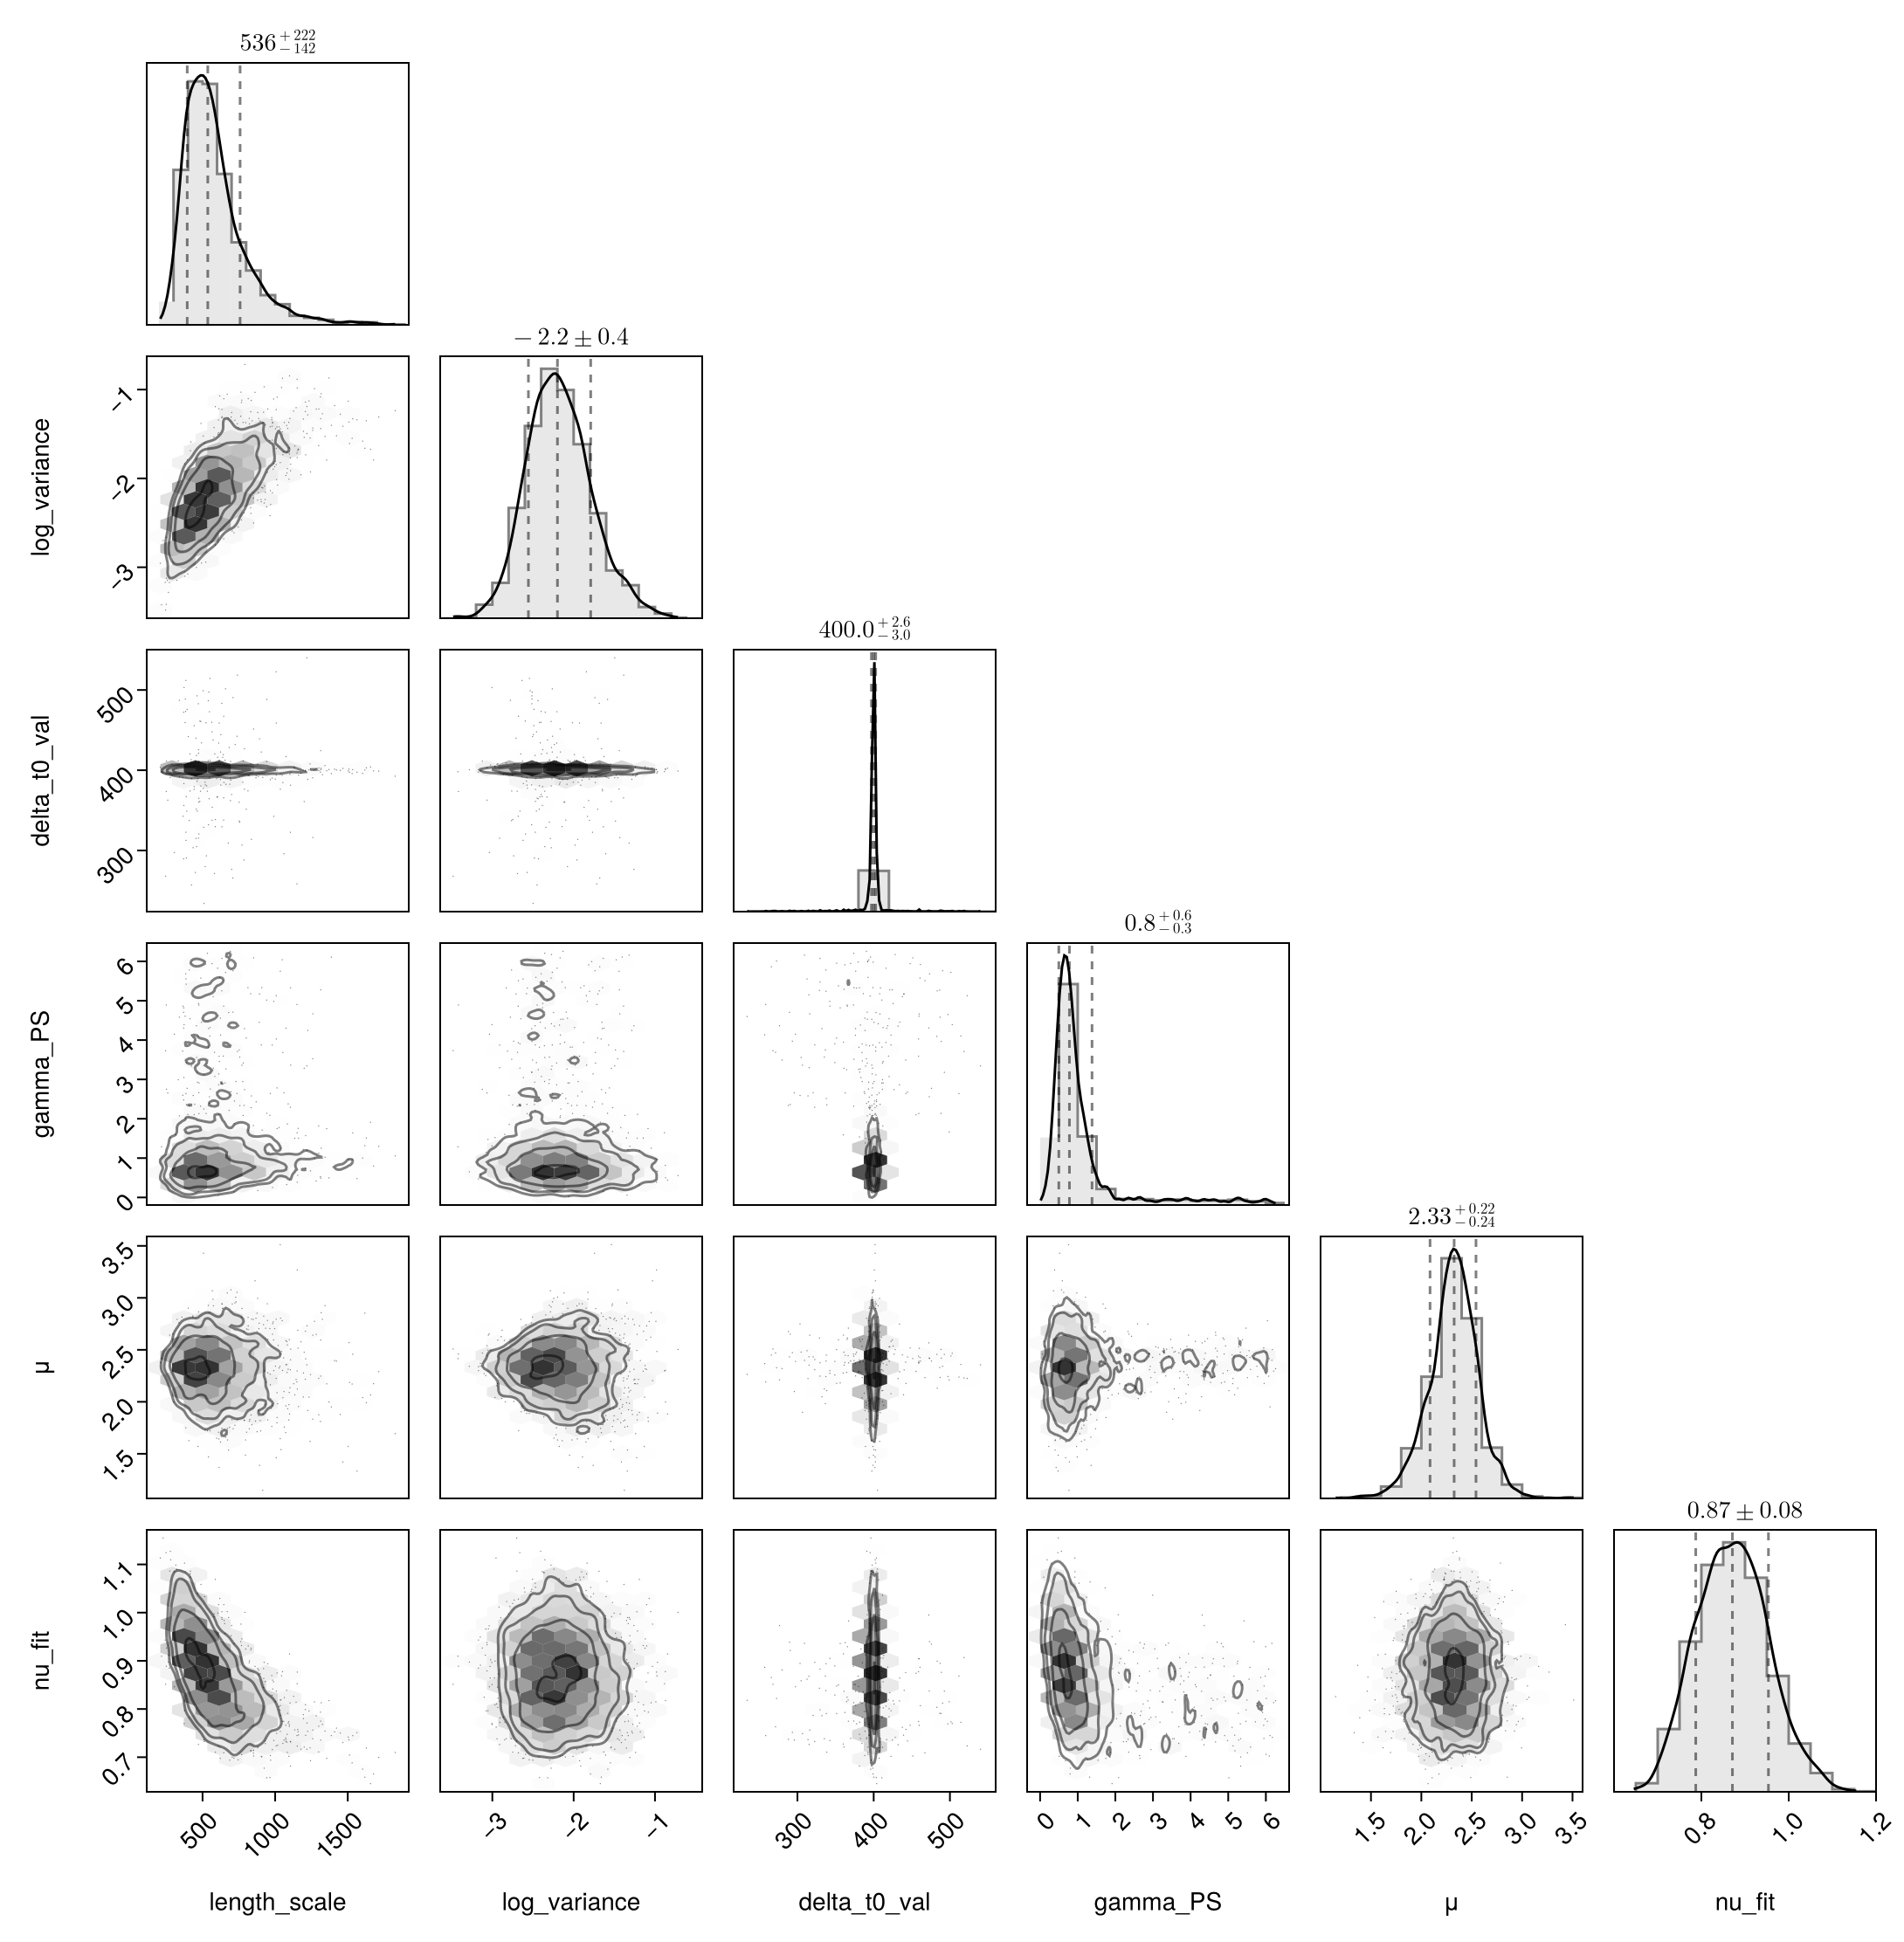

CairoMakie.Screen{IMAGE}


In [17]:
using CairoMakie
using PairPlots
pair_plot = PairPlots.pairplot(chain_obj)
display(pair_plot)

In [ ]:
params, internals = MCMCChains.get_sections(chain_obj)

my_plot2 = StatsPlots.plot(internals)
my_plot2

In [ ]:
# Extract parameter names and values from the chain
param_names = names(params)
println("Parameter names: ", param_names)
println("Internal variable names: ", names(internals))

# Try different possible names for log probability
log_prob_candidates = [:log_density, :logpotential, :energy, :log_likelihood]
log_probs = nothing

for candidate in log_prob_candidates
    if candidate in names(internals)
        log_probs = internals[candidate].data[:, 1]
        println("Using $(candidate) for log probabilities")
        break
    end
end

if log_probs === nothing
    println("Available internals: ", names(internals))
    error("Could not find log probability variable in internals")
end

plots_list = []

for param_name in param_names
    # Get the parameter values from the chain
    param_values = params[param_name].data[:, 1]  # assuming single chain
    
    p = plot(param_values, log_probs, 
               xlabel=string(param_name), 
               ylabel="Log Probability",
               title="Profile: $(param_name)",
               seriestype=:scatter,
               alpha=0.6,
               markersize=2,
               legend=false)
    
    push!(plots_list, p)
end

# Calculate layout dimensions
n_params = length(param_names)
n_cols = min(3, n_params)
n_rows = ceil(Int, n_params / n_cols)

# Combine all plots
combined_plot = plot(plots_list..., 
                    layout=(n_rows, n_cols), 
                    size=(300*n_cols, 250*n_rows))

display(combined_plot)

#Still not sure about this cell's usefulness, and it may have errors. Working on it. 
#You can skip for now if you don't find it useful. 

In [ ]:
# Function to extract parameter values from Pigeons samples
function extract_parameters(pt)
    chain_data = sample_array(pt)
    param_names = ["length_scale", "log_variance", "delta_t0_val", "gamma_PS", "μ", "nu_fit"]

    samples = []
    n_samples = size(chain_data, 1)
    
    for i in 1:n_samples
        sample = [chain_data[i, j] for j in 1:6]  # Assuming 6 parameters
        push!(samples, sample)
    end
    
    return samples
end
    
# Posterior predictive sampling
function posterior_predictive(pt, t, flux_obs, n_functions_per_sample=40)
    samples = extract_parameters(pt)
    n_posterior_samples = length(samples)
    n_obs = length(t)
    all_sampled_fluxes = []
    
    @showprogress for i in 1:n_posterior_samples
        θ = samples[i]
        length_scale = θ[1]
        log_variance = θ[2]
        delta_t0_val = θ[3]
        gamma_PS = θ[4]
        μ = θ[5]
        nu_fit = θ[6]
        
        delta_t0_dynamic = fill(delta_t0_val, length(t))
        
        # Create combined time vector with both zeroth-order and delayed times
        t_combined = vcat(t, t .- delta_t0_dynamic)
        
        # Build GP Model with constant mean and combined kernel
        variance = exp(log_variance)
        mean_func = ConstMean{Float64}(μ)
        
        # Kernel setup - using the same kernel from your model
        Matern32 = with_lengthscale(Matern32Kernel(), length_scale)
        k_base   = MaternKernel(; ν = nu_fit) 
        k_scaled = with_lengthscale(k_base, length_scale)
        kernel = variance * k_scaled
        gp = GP(mean_func, kernel)
        
        # Evaluate the GP at observed times
        f_t_obs = gp(t)
        
        # Compute the posterior GP conditioned on flux observations at t
        try
            posterior_gp = posterior(f_t_obs, flux_obs)
            
            # Make predictions at t_combined using the posterior GP
            f_t_combined = posterior_gp(t_combined)
            
            # Now extract the covariance and mean for F0 and F1
            cov_total = cov(f_t_combined) #.+ 1e-5 .* I(length(t_combined)) 
            mean_total = mean(f_t_combined)
            
            # Extract the covariance blocks for F0 (zeroth-order) and F1 (first-order)
            indices_F0 = 1:n_obs
            indices_F1 = (n_obs + 1):(2 * n_obs)
            
            # Covariance matrices
            cov_F0 = cov_total[indices_F0, indices_F0]
            cov_F1 = cov_total[indices_F1, indices_F1]
            cov_F0F1 = cov_total[indices_F0, indices_F1]
            
            # Means
            mean_F0 = mean_total[indices_F0]
            mean_F1 = mean_total[indices_F1]
            
            # Compute the total mean flux including the delayed component
            exp_neg_gamma_PS = exp(-gamma_PS)
            total_mean = mean_F0 .+ exp_neg_gamma_PS .* mean_F1
            
            # Compute the total covariance
            total_cov = cov_F0 .+ 
                    (exp_neg_gamma_PS^2) .* cov_F1 .+ 
                    exp_neg_gamma_PS .* (cov_F0F1 .+ transpose(cov_F0F1))
            #total_cov .+= 1e-6 * I(n_obs)  # Add jitter to total covariance for stability
            total_cov = Symmetric(total_cov)
            
            # Sample from the predictive distribution
            for j in 1:n_functions_per_sample
                # Draw a sample from the multivariate normal distribution
                sampled_flux = rand(MvNormal(mean_F0, total_cov))
                
                # Store sampled flux for plotting
                push!(all_sampled_fluxes, (t, sampled_flux))
            end
        catch e
            if isa(e, PosDefException)
                println("Covariance matrix not positive definite at iteration $i")
                continue
            else
                rethrow(e)
            end
        end
    end
    
    return all_sampled_fluxes
end

# Function to plot the results
function plot_posterior_predictive(t, flux_obs, all_sampled_fluxes, n_curves_to_plot=200)
    
    # Convert the stored sampled fluxes to a matrix for easier computation
    sampled_flux_matrix = hcat([flux for (_, flux) in all_sampled_fluxes]...)
    
    # Compute the posterior predictive mean
    posterior_predictive_mean = mean(sampled_flux_matrix, dims=2)
    
    # Plotting the results
    plt = Plots.plot(
        xlabel = "Observer Time [s]",
        ylabel = "Flux [Jy]",
        title = "Posterior Predictive Mean from the GP",
        legend = :best,
        size = (800, 600)
    )
    
    # Plot the observed flux data
    Plots.plot!(plt, t, flux_obs; label = "Observed Flux", lw = 3, color = "blue")
    
    # Plot a subset of the sampled flux curves
    n_to_plot = min(n_curves_to_plot, length(all_sampled_fluxes))
    sampled_fluxes_to_plot = all_sampled_fluxes[1:n_to_plot]
    
    for (i, (t_sample, flux_sample)) in enumerate(sampled_fluxes_to_plot)
        Plots.plot!(
            plt,
            t_sample,
            flux_sample;
            lw = 1,
            color = "red",
            alpha = 0.1,
            label = (i == 1 ? "Sampled Fluxes" : "")
        )
    end
    
    # Plot the posterior predictive mean
    Plots.plot!(plt, t, posterior_predictive_mean; label = "Predictive Mean", lw = 2, color = "orange")
    
    return plt
end

In [ ]:
all_sampled_fluxes = posterior_predictive(pt, t, flux_obs)
plt = plot_posterior_predictive(t, flux_obs, all_sampled_fluxes)
display(plt)

In [14]:
using JLD2

#cd("/home/dashon/Documents")
# Save the chain object
save("Test_Turbulence_Data_loop2.jld2", "chain", chain_obj)

#This works to save the sample data, to be used for cluster script

In [16]:
# Later, to load it
chain_loaded = load("Test_Turbulence_Data.jld2", "chain")

Chains MCMC chain (2048×7×1 Array{Float64, 3}):

Iterations        = 1:1:2048
Number of chains  = 1
Samples per chain = 2048
parameters        = length_scale, log_variance, delta_t0_val, gamma_PS, μ, nu_fit
internals         = log_density

Summary Statistics
    parameters       mean        std   naive_se      mcse         ess      rha ⋯
        Symbol    Float64    Float64    Float64   Float64     Float64   Float6 ⋯

  length_scale   580.6036   213.9829     4.7284   14.7827    186.1104    1.000 ⋯
  log_variance    -2.1715     0.3972     0.0088    0.0244    248.2776    1.001 ⋯
  delta_t0_val   399.1675    18.3189     0.4048    0.4238   2355.5207    1.000 ⋯
      gamma_PS     1.1184     1.0921     0.0241    0.0521    322.2784    1.011 ⋯
             μ     2.3184     0.2478     0.0055    0.0058   2106.0117    1.000 ⋯
        nu_fit     0.8723     0.0817     0.0018    0.0039    282.2795    1.000 ⋯
                                                                1 column omitted

Quantiles


In [13]:
LC_df = DataFrame(time=t, F_nu=flux_obs)
CSV.write("Test_Accretion_Turbulence_LC_loop2.csv", LC_df)

"Test_Accretion_Turbulence_LC_loop2.csv"

## Constant delta_t0 with time dep. gamma_PS

In [13]:
# Define modified hotspot angle functions that use the sampled Ω
function T_K_withΩ(Ω::Real)
    return 2.0 * π / Ω
end

function phi_e_Hotspot_withΩ(i::Real, r::Real, t::Real, Ω::Real)
    T_K_Val = T_K_withΩ(Ω)
    tan_phi_e = cos(i) * tan(Ω * t)
    arctan_tan_phi_e = atan(tan_phi_e)
    
    phi_e_Val = 0.0
    
    if T_K_Val*(0.0/4.0) <= t < T_K_Val*(1.0/4.0)
        phi_e_Val = arctan_tan_phi_e + 0.0*π
    elseif T_K_Val*(1.0/4.0) <= t < T_K_Val*(3.0/4.0)
        phi_e_Val = arctan_tan_phi_e + 1.0*π
    elseif T_K_Val*(3.0/4.0) <= t < T_K_Val*(5.0/4.0)
        phi_e_Val = arctan_tan_phi_e + 2.0*π
    elseif T_K_Val*(5.0/4.0) <= t < T_K_Val*(7.0/4.0)
        phi_e_Val = arctan_tan_phi_e + 3.0*π
    elseif T_K_Val*(7.0/4.0) <= t < T_K_Val*(9.0/4.0)
        phi_e_Val = arctan_tan_phi_e + 4.0*π
    end
    
    return phi_e_Val
end

function th_e_Hotspot_withΩ(i::Real, r::Real, t::Real, Ω::Real)
    T_K_Val = T_K_withΩ(Ω)
    arctan_tan_th_e = -atan(1.0/(tan(i)*sin(phi_e_Hotspot_withΩ(i, r, t, Ω))))
    
    th_e_Val = 0.0
    
    if T_K_Val*(0.0/4.0) <= t < T_K_Val*(2.0/4.0)
        th_e_Val = arctan_tan_th_e + π
    elseif T_K_Val*(2.0/4.0) <= t < T_K_Val*(4.0/4.0)
        th_e_Val = arctan_tan_th_e
    elseif T_K_Val*(4.0/4.0) <= t < T_K_Val*(6.0/4.0)
        th_e_Val = arctan_tan_th_e + π
    elseif T_K_Val*(6.0/4.0) <= t < T_K_Val*(8.0/4.0)
        th_e_Val = arctan_tan_th_e
    elseif T_K_Val*(8.0/4.0) <= t < T_K_Val*(10.0/4.0)
        th_e_Val = arctan_tan_th_e + π
    end
    
    return th_e_Val
end

@model function blackhole_gp_model(t, flux_obs, var_empirical, delta_t0_analytic)
    # Priors
    mean_flux = mean(flux_obs)
    length_scale  ~ Truncated(Gamma(10, 187.91180901703703), 75, 3000)
    log_variance ~ Truncated(
                  Normal(log(var_empirical), 0.5),
                  log(1e-12), Inf) #To avoid Scaled kernel error
    
    # Constant delta_t0 - similar to the original model
    delta_t0_val  ~ Normal(delta_t0_analytic, 70.0)
    
    # Orbital velocity parameter (sampling in log space)
    logΩ          ~ Normal(log(1/6^(3/2)), 0.3)      # Log of angular velocity
    Ω = exp(logΩ)                                    # Actual angular velocity
    
    # Fixed parameters 
    r = 6.0                         # Fixed orbital radius at 6M
    i ~ Uniform(0.0, π/2)           # Inclination angle in radians
    
    μ ~ Normal(mean_flux, 1.0)
    
    # Calculate time-dependent theta_e using modified functions with sampled Ω
    theta_e = zeros(length(t))
    for (idx, time) in enumerate(t)
        theta_val = th_e_Hotspot_withΩ(i, r, time, Ω)
        theta_e[idx] = mod(theta_val, π)  # Ensure values are between 0 and π
    end
    
    # Calculate time-dependent gamma weights using theta_e
    gamma_PS_t = 2.0 .* (1.0 .- theta_e ./ π)
    
    # Build Time Arrays with constant delta_t0
    delta_t0_mean = fill(delta_t0_val, length(t))
    t_combined = vcat(t, t .- delta_t0_mean)

    # Construct Mean & Kernel
    mean_func = ConstMean{Float64}(μ)
    variance = exp(log_variance)

    # Kernel
    kernel = variance * with_lengthscale(Matern12Kernel(), length_scale)

    gp = GP(mean_func, kernel)

    f_t = gp(t_combined)
    mean_flux = mean(f_t)
    covariance = cov(f_t)

    # Extract F0 and F1 blocks
    n_obs = length(t)
    idxF0 = 1:n_obs
    idxF1 = (n_obs+1):(2*n_obs)

    mean_F0 = @view mean_flux[idxF0]
    mean_F1 = @view mean_flux[idxF1]
    cov_F0 = @view covariance[idxF0, idxF0]
    cov_F1 = @view covariance[idxF1, idxF1]
    cov_F0F1 = @view covariance[idxF0, idxF1]

    total_mean = mean_F0 .+ exp.(-gamma_PS_t) .* mean_F1

    # We need a matrix for the covariance computation
    total_cov = cov_F0
    
    # Add the F1 contribution with time-dependent gamma values
    for i in 1:n_obs
        for j in 1:n_obs
            # Add the exp(-gamma_PS_t[i]) * exp(-gamma_PS_t[j]) * cov_F1[i,j] term
            total_cov[i,j] += exp(-gamma_PS_t[i]) * exp(-gamma_PS_t[j]) * cov_F1[i,j]
            
            # Add the cross-terms
            total_cov[i,j] += exp(-gamma_PS_t[i]) * cov_F0F1[j,i]
            total_cov[i,j] += exp(-gamma_PS_t[j]) * cov_F0F1[i,j]
        end
    end

    total_cov_sym = Symmetric(total_cov)
    try
        flux_obs ~ MvNormal(mean_F0, total_cov_sym)
    catch e
        if isa(e, PosDefException)
            Turing.@addlogprob! -Inf     # soft-reject this draw
        else
            rethrow(e)                   # propagate unrelated errors
        end
    end
end

blackhole_gp_model (generic function with 2 methods)

In [14]:
delta_t0_analytic = 400.2672182312732/tM_to_s
t_geom = t/tM_to_s
my_model_instance = blackhole_gp_model(t_geom, flux_obs, var_empirical, delta_t0_analytic)

# Convert the Turing model to a LogPotential for use with Pigeons:
my_turing_potential = TuringLogPotential(my_model_instance)

TuringLogPotential{...}(DynamicPPL.Model{typeof(blackhole_gp_model), (:t, :flux_obs, :var_empirical, :delta_t0_analytic), (), (), Tuple{Vector{Float64}, Vector{Float64}, Float64, Float64}, Tuple{}, DynamicPPL.DefaultContext}(Main.blackhole_gp_model, (t = [0.0, 0.9842566436112122, 1.9685132872224245, 2.9527699308336364, 3.9370314888969786, 4.921283218056061, 5.905549690571533, 6.889816163087004, 7.874082635602476, 8.85829996359665  …  167.32382599199127, 168.30819075354933, 169.29206406989445, 170.27642883145248, 171.26079359301056, 172.24515835456862, 173.2295231161267, 174.2133964324718, 175.19776119402985, 176.1821259555879], flux_obs = [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0  …  2.986150728311157, 2.98883963339002, 2.983614204473689, 2.9770685825297143, 2.9693298999690447, 2.9612367984722976, 2.952670343162657, 2.9437330321827138, 2.9346060733833133, 2.9250057609697784], var_empirical = 0.06551074474124906, delta_t0_analytic = 19.670940830441165), NamedTuple(), DynamicPPL.

In [15]:
using MCMCChains

@time pt = pigeons(
    target   = my_turing_potential,
    n_chains = 2,          # Number of chains for parallel tempering
    #multithreaded = true,   #Take out if not necessary for your runs
    n_rounds = 10,     
    record   = [traces, online]  # Record in-memory samples and online stats
)

# After sampling, you can convert the samples to a Chains object for analysis
chain_data = sample_array(pt)


────────────────────────────────────────────────────────────────────────────
  scans        Λ      log(Z₁/Z₀)   min(α)     mean(α)    min(αₑ)   mean(αₑ) 
────────── ────────── ────────── ────────── ────────── ────────── ──────────
        2          1       -792          0          0          1          1 
        4          1       -521          0          0          1          1 
        8          1       -271          0          0          1          1 
       16          1        111  2.68e-185  2.68e-185          1          1 
       32          1       3.86  9.91e-279  9.91e-279          1          1 
       64          1        156  9.04e-162  9.04e-162      0.997      0.997 
      128          1        166  3.78e-154  3.78e-154      0.999      0.999 
      256          1        213  2.05e-113  2.05e-113      0.999      0.999 
      512          1        215  4.97e-112  4.97e-112      0.998      0.998 
 1.02e+03          1        289   3.08e-45   3.08e-45      0.998      0.998 

1024×7×1 Array{Float64, 3}:
[:, :, 1] =
  860.03   -0.86001   143.993   -1.95398  1.53596  2.53063  323.036
  817.669  -0.829978  135.041   -1.93137  1.52049  2.21773  322.33
  931.058  -0.745436  146.73    -1.95825  1.5573   2.24893  322.055
  813.315  -0.806007  144.76    -1.96306  1.55644  2.70398  320.866
  908.067  -0.905952  268.615   -2.21279  1.4957   2.21815  314.599
 1034.3    -0.553998  145.236   -1.95777  1.52375  1.83812  319.327
 1048.08   -0.540005  133.161   -1.98798  1.52559  2.47181  320.538
  829.458  -0.71772    61.3484  -1.9751   1.55945  2.58974  322.739
  820.022  -0.951987   61.3074  -1.93997  1.52541  2.7706   324.855
  800.384  -0.950276   56.1416  -1.95844  1.49615  2.49041  323.446
  926.952  -0.867281   60.7295  -1.95382  1.51695  2.64898  325.077
  702.208  -0.909288   60.1182  -1.92461  1.55645  2.80824  323.544
  601.407  -0.755188   58.1743  -1.95584  1.50742  2.7332   318.822
    ⋮                                              ⋮        
  361.139  -1.65

In [16]:
chain_obj2  = Chains(pt)

Chains MCMC chain (1024×7×1 Array{Float64, 3}):

Iterations        = 1:1:1024
Number of chains  = 1
Samples per chain = 1024
parameters        = length_scale, log_variance, delta_t0_val, logΩ, i, μ
internals         = log_density

Summary Statistics
    parameters       mean        std   naive_se      mcse         ess      rha ⋯
        Symbol    Float64    Float64    Float64   Float64     Float64   Float6 ⋯

  length_scale   678.7581   240.6670     7.5208   18.9321    135.9321    1.012 ⋯
  log_variance    -1.1049     0.3504     0.0109    0.0274    155.3098    1.005 ⋯
  delta_t0_val   101.3869    45.1496     1.4109    6.4845      5.6395    1.261 ⋯
          logΩ    -1.9846     0.0907     0.0028    0.0086     14.6471    1.108 ⋯
             i     1.5285     0.0345     0.0011    0.0010   1091.7254    1.003 ⋯
             μ     2.4286     0.2992     0.0094    0.0368      8.2247    1.176 ⋯
                                                                1 column omitted

Quantiles
    param

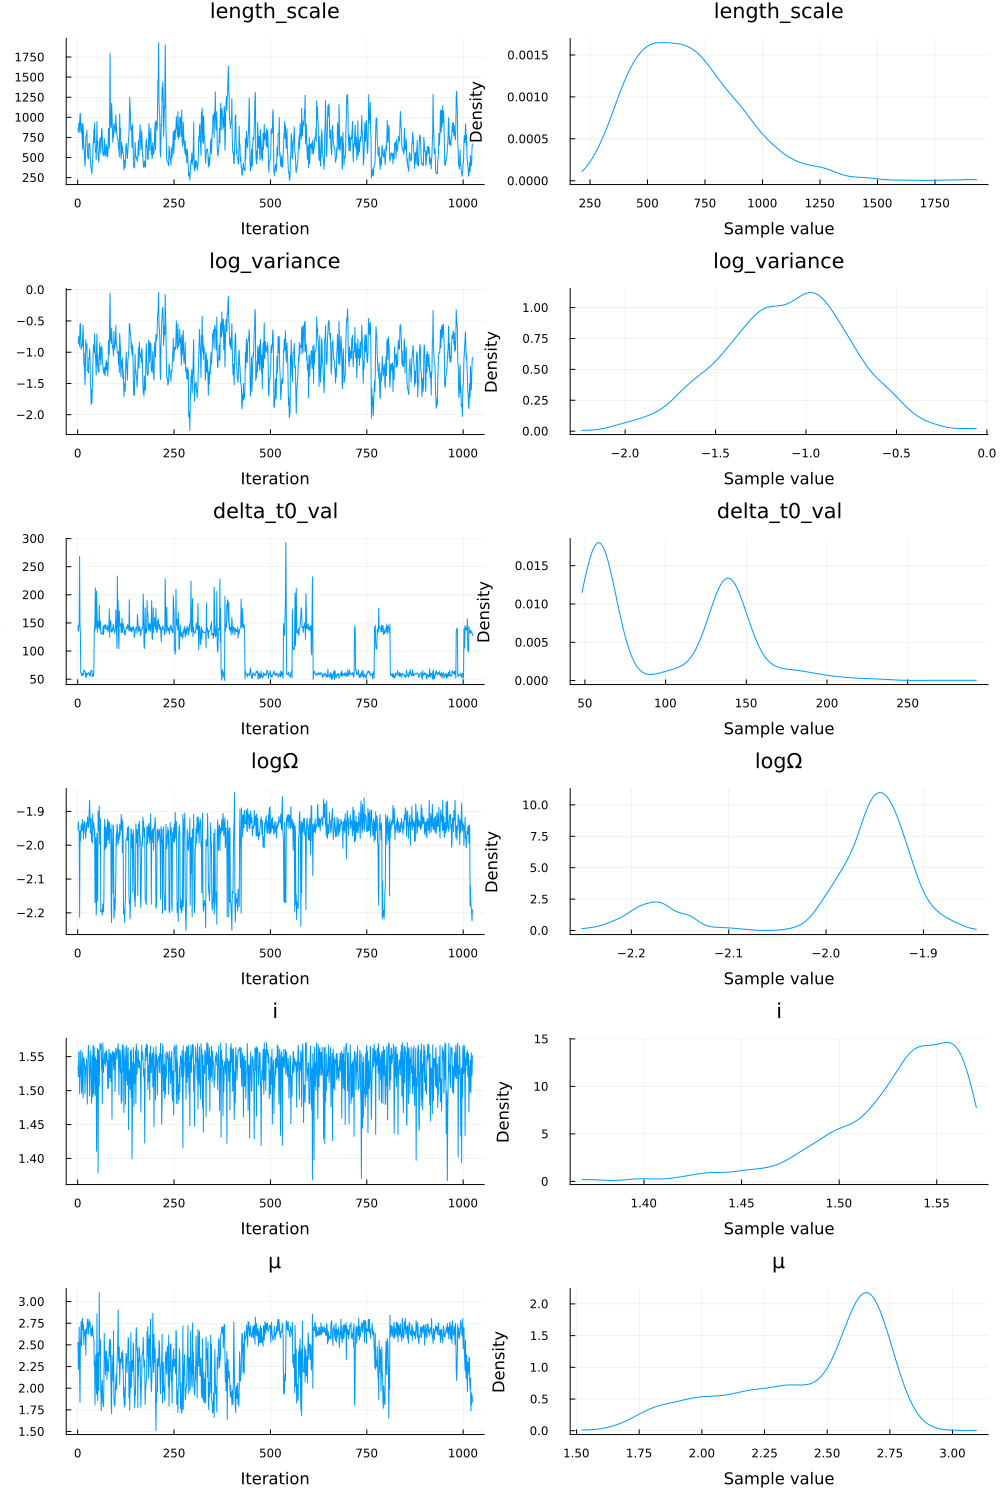

In [17]:
my_plot2 = StatsPlots.plot(chain_obj2)